In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

In [43]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, classification_report, silhouette_score

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [4]:
char_df = pd.read_csv('data/dd_bios_02.csv', encoding='ISO-8859-1')

char_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3447 entries, 0 to 3446
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   timestamp            2447 non-null   object
 1   character_name       3447 non-null   object
 2   character_species    3447 non-null   object
 3   character_class      3447 non-null   object
 4   character_backstory  3343 non-null   object
dtypes: object(5)
memory usage: 134.8+ KB


In [5]:
char_df = char_df.drop(columns=['timestamp'])

In [6]:
char_df = char_df.dropna()

In [7]:
# Convert all values in the 'character_species' and 'character_class' column to lowercase
char_df['character_species'] = char_df['character_species'].str.lower()
char_df['character_class'] = char_df['character_class'].str.lower()
char_df['character_name'] = char_df['character_name'].str.lower()
char_df['character_backstory'] = char_df['character_backstory'].str.lower()


# Verify the change
char_df['character_species'].unique()

array(['aarakocra', 'aasamar', 'aasimar', 'alien', 'android',
       'anthropomorphic cockroach', 'aquatic half-elf', 'beeforged',
       'birali (homebrew, sort of like a cat-folk)',
       'birali turned back to human', 'birdfolk', 'blue dragonborn',
       'bugbear', 'cambion', 'catfolk', 'catgirl', 'celestial',
       'changeling', 'copper dragonborn', 'dark elf', 'dark elf/human',
       'deep gnome', 'demon', 'dragonborn', 'drow', 'drow elf', 'dwarf',
       'earth genasi', 'eladrin', 'elan', 'elf', 'elf (drow)',
       'elf (wood)', 'fey corgi', 'feyblood', 'fire genasi',
       'forest gnome', 'genasi', 'ghostwise halfling', 'ghoul medusa',
       'githyanki', 'gnoll', 'gnome', 'goblin', 'goliath', 'grey elf',
       'hafling', 'half cat folk/ half elf', 'half drow',
       "half dwarf, half elf/orc (don't question it)", 'half elf',
       'half orc', 'half-dragon half-elf', 'half-drow',
       'half-dwarf / half-ogre', 'half-elf', 'half-elf (drow)',
       'half-orc', 'half-or

In [8]:
def replace_string_in_column(df, column, old_string, new_string):
    """
    Replaces occurrences of a specific string in a column with a new string.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the column.
    column (str): The column name where the replacement should happen.
    old_string (str): The string to search for.
    new_string (str): The string to replace the old one with.

    Returns:
    pd.DataFrame: The DataFrame with the updated column.
    """
    df.loc[df[column].str.contains(old_string, case=False, na=False), column] = new_string
    return df

In [9]:
# We can clean up some glaring issues. There are still a lot of homebrew species, we will leave them as is. 

char_df = replace_string_in_column(char_df, 'character_species', 'aasamar', 'aasimar')
char_df = replace_string_in_column(char_df, 'character_species', 'half elf', 'half-elf')
char_df = replace_string_in_column(char_df, 'character_species', 'half drow', 'half-elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'half-drow', 'half-elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'half-ord', 'half-orc')
char_df = replace_string_in_column(char_df, 'character_species', 'drow', 'elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'drow elf', 'elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'humam', 'human')

In [24]:
# Combine 'character_name', 'character_species', and 'character_class' into a single input text feature
char_df['input_text'] = char_df['character_name'] + ' ' + char_df['character_species'] + ' ' + char_df['character_class']

# Define features (X) and target (y)
X = char_df[['input_text']]
y = char_df[['character_backstory']]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
X_train.head()

,input_text
1157,marco fallacy human pirate
3363,bryn vulpin ranger
709,hideyama kurimasa human samurai
1595,oswin elf cleric
1748,brother aegis tortle cleric


In [26]:
y_train.head()

,character_backstory
1157,he is wrong like all the time.
3363,"bryn is a vulpin ranger, known for their unmat..."
709,_hideyama kurisuma is a true warrior. with str...
1595,"as a child he was sent to live alone, tending ..."
1748,brother aegis carries the faith of universal l...


In [28]:
from nltk.tokenize import RegexpTokenizer

basic_token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(basic_token_pattern)


In [29]:
X_train

,input_text
1157,marco fallacy human pirate
3363,bryn vulpin ranger
709,hideyama kurimasa human samurai
1595,oswin elf cleric
1748,brother aegis tortle cleric
...,...
1128,sgt. eric bruce lee human police officer
1163,auri human cleric
1333,binyamin elf fighter
884,hashanna half silver dragon paladin


In [30]:
y_train

,character_backstory
1157,he is wrong like all the time.
3363,"bryn is a vulpin ranger, known for their unmat..."
709,_hideyama kurisuma is a true warrior. with str...
1595,"as a child he was sent to live alone, tending ..."
1748,brother aegis carries the faith of universal l...
...,...
1128,sergeant eric bruce lee is a golden gate park ...
1163,auri's older twin brothers were next in line t...
1333,"lived on a farm, but when he inherited and was..."
884,hashannas' story begins with her parents. \n\n...


In [31]:
X_train['input_tokenized'] = X_train['input_text'].apply(tokenizer.tokenize)
y_train['backstory_tokenized'] = y_train['character_backstory'].apply(tokenizer.tokenize)

In [32]:
# Run this cell without changes
from nltk import FreqDist

example_freq_dist = FreqDist(y_train.iloc[100]["backstory_tokenized"][:20])
example_freq_dist

FreqDist({'of': 2, 'aven': 2, 'the': 1, 'tragic': 1, 'history': 1, 'young': 1, 'tibib': 1, 'was': 1, 'abducted': 1, 'by': 1, ...})

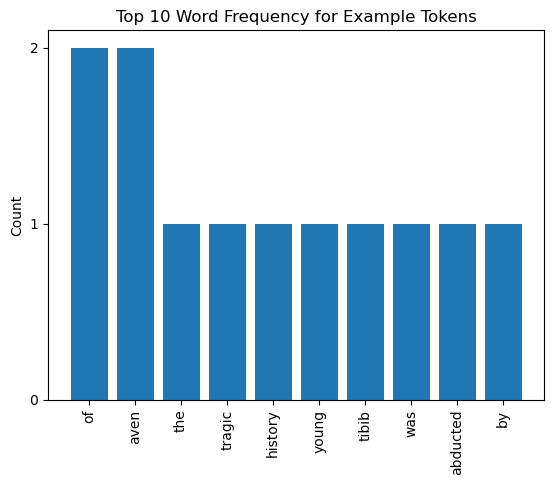

In [33]:
from matplotlib.ticker import MaxNLocator

def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    
visualize_top_10(example_freq_dist, "Top 10 Word Frequency for Example Tokens")

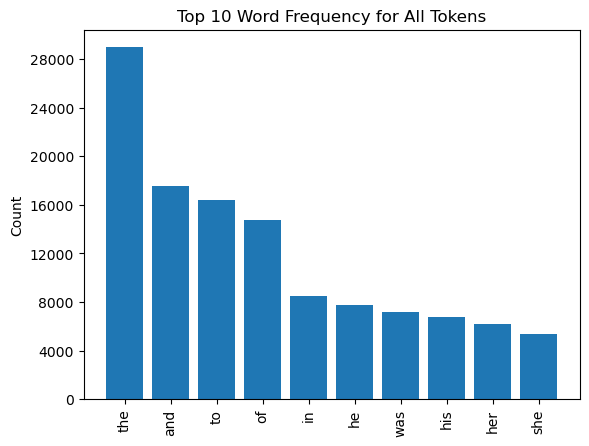

In [34]:
# Create a frequency distribution for y_train
train_freq_dist = FreqDist(y_train["backstory_tokenized"].explode())

# Plot the top 10 tokens
visualize_top_10(train_freq_dist, "Top 10 Word Frequency for All Tokens")

In [39]:
# Instantiate a vectorizer with max_features=10
# (we are using the default token pattern)
tfidf = TfidfVectorizer(max_features=10)

X_train_vectorized = tfidf.fit_transform(X_train["input_text"])

# Visually inspect the 10 most common words
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names_out())

,bard,cleric,elf,fighter,half,human,paladin,rogue,warlock,wizard
0,0,0,0,0,0,1.0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1.0,0,0,0,0
3,0,0.764174,0.645011,0,0,0,0,0,0,0
4,0,1.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2669,0,0,0,0,0,1.0,0,0,0,0
2670,0,0.806525,0,0,0,0.5912,0,0,0,0
2671,0,0,0.653247,0.757145,0,0,0,0,0,0
2672,0,0,0,0,0.651517,0,0.758634,0,0,0


In [40]:
# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(y_train["character_backstory"])

# Visually inspect the 10 most common words
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names_out())

,and,he,her,his,in,of,she,the,to,was
0,0,0.866762,0,0,0,0,0,0.498722,0,0
1,0.546115,0,0,0,0.303569,0.278777,0,0.676508,0.272442,0
2,0.258868,0.567458,0,0.378491,0.156978,0.224246,0,0.481986,0.234804,0.324578
3,0.141318,0.730194,0,0.243518,0,0.288556,0,0.280095,0.422997,0.216565
4,0.307317,0,0,0.529566,0,0.522924,0,0.507591,0.306624,0
...,...,...,...,...,...,...,...,...,...,...
2669,0.298358,0.513876,0,0.367235,0.236926,0.348123,0,0.549114,0.170106,0.065318
2670,0.13616,0,0.566413,0,0.151374,0.139012,0.290113,0.269873,0.679265,0
2671,0.22824,0.786215,0,0,0,0,0,0,0.455449,0.34977
2672,0.419203,0.038001,0.734251,0.038019,0.147172,0.315357,0.09402,0.30611,0.132081,0.202868


In [45]:
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

stopwords_list = stopwords.words('english')
stopwords_list[:20]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

In [46]:
# Run this cell without changes
print("Original list length:", len(stopwords_list))
stopwords_list.pop(stopwords_list.index("for"))
print("List length after removing 'for':", len(stopwords_list))

Original list length: 179
List length after removing 'for': 178


In [47]:
def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    return [token for token in token_list if token not in stopwords_list]

In [49]:
tokens_example = y_train.iloc[100]["backstory_tokenized"]
print("Length with stopwords:", len(tokens_example))


tokens_example_without_stopwords = remove_stopwords(tokens_example)
print("Length without stopwords:", len(tokens_example_without_stopwords))


Length with stopwords: 1132
Length without stopwords: 616


In [51]:
X_train["input_without_stopwords"] = X_train["input_tokenized"].apply(remove_stopwords)
y_train["backstory_without_stopwords"] = y_train["backstory_tokenized"].apply(remove_stopwords)

In [53]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(
    max_features=10,
    stop_words=stopwords_list
)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["input_text"])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names_out())

,bard,cleric,elf,fighter,half,human,paladin,rogue,warlock,wizard
0,0,0,0,0,0,1.0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1.0,0,0,0,0
3,0,0.764174,0.645011,0,0,0,0,0,0,0
4,0,1.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2669,0,0,0,0,0,1.0,0,0,0,0
2670,0,0.806525,0,0,0,0.5912,0,0,0,0
2671,0,0,0.653247,0.757145,0,0,0,0,0,0
2672,0,0,0,0,0.651517,0,0.758634,0,0,0


In [54]:
# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()

In [56]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language="english")

def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]

In [58]:
print("Original sample:", y_train.iloc[100]["backstory_tokenized"][20:30])
print("Stemmed sample: ", stem_and_tokenize(y_train.iloc[100]["character_backstory"])[20:30])

Original sample: ['that', 'night', 'besides', 'fire', 'and', 'the', 'lamentations', 'of', 'the', 'dying']
Stemmed sample:  ['that', 'night', 'besid', 'fire', 'and', 'the', 'lament', 'of', 'the', 'die']


In [59]:
stemmed_stopwords = [stemmer.stem(word) for word in stopwords_list]

In [60]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(
    max_features=10,
    stop_words=stemmed_stopwords,
    tokenizer=stem_and_tokenize
)

# Fit the vectorizer on X_train["text"] and transform it
y_train_vectorized = tfidf.fit_transform(y_train["character_backstory"])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(y_train_vectorized, columns=tfidf.get_feature_names_out())

c:\Users\dmm46\miniconda3\envs\tf-gpu\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,could,face,famili,for,one,time,way,world,would,yet
0,0,0,0,0,0,1.0,0,0,0,0
1,0,0.663815,0,0.196615,0,0,0.269286,0.255245,0,0.618892
2,0,0.077283,0,0.412027,0.20889,0.400888,0,0.059432,0.785101,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0.589083,0,0.530467,0,0,0.609579
...,...,...,...,...,...,...,...,...,...,...
2669,0,0,0,0.795981,0.605322,0,0,0,0,0
2670,0,0,0,0,0,0,0,0,0,0
2671,0,0,0,0,0,0,0,0,0,0
2672,0,0.590746,0,0,0,0,0,0.454297,0.666808,0


In [62]:
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

sent_tokenize(y_train.iloc[100]["character_backstory"])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dmm46\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\dmm46\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


['the tragic history of young aven tibib\n\naven was abducted by raptic elves at age five.',
 'she remembers little of that night, besides fire and the lamentations of the dying.',
 'her memories of her tiefling life are hazy.',
 'she dimly remembers her mother?s face, the warmth of her arms, and scraps of stories.',
 'she was taken to faiontis on the island of abaivoi, and sold to an ancient, skilled and highly respected cnila-barmoi warlock named presbutermen of clan trinepsios.',
 'he was brilliant, wholly devoted to uncovering demonic mysteries, and not much interested in raptic politics or clan competition.',
 'aven was her tiefling name.',
 'the warlock gave her the name tibib to be used in his household, in the language of his people.',
 'some in the household treated her kindly, some indifferently.',
 'even presbutermen was kind in his way.',
 'but his fondness for the girl did not prevent him in any way from using her for his dark ends.',
 'to summon and bind a demon, one must

In [63]:
y_train["num_sentences"] = y_train["character_backstory"].apply(lambda x: len(sent_tokenize(x)))

In [64]:
price_query = r'\$(?:\d{1,3}[,.]?)+(?:\\d{1,2})?'

y_train["contains_price"] = y_train["character_backstory"].str.contains(price_query)

In [65]:
emoticon_query = r'(?:[\:;X=B][-^]?[)\]3D([OP/\\|])(?:(?=\s))'

y_train["contains_emoticon"] = y_train["character_backstory"].str.contains(emoticon_query)

In [67]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(
    max_features=10,
    stop_words=stemmed_stopwords,
    tokenizer=stem_and_tokenize
)

# Fit the vectorizer on X_train["text"] and transform it
y_train_vectorized = tfidf.fit_transform(y_train["character_backstory"])

# Create a full df of vectorized + engineered features
y_train_vectorized_df = pd.DataFrame(y_train_vectorized.toarray(), columns=tfidf.get_feature_names_out())
preprocessed_y_train = pd.concat([
    y_train_vectorized_df, y_train[["num_sentences", "contains_price", "contains_emoticon"]]
], axis=1)
preprocessed_y_train

c:\Users\dmm46\miniconda3\envs\tf-gpu\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,could,face,famili,for,one,time,way,world,would,yet,num_sentences,contains_price,contains_emoticon
0,0.0,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
1,0.0,0.663815,0.0,0.196615,0.000000,0.000000,0.269286,0.255245,0.000000,0.618892,14.0,False,False
2,0.0,0.077283,0.0,0.412027,0.208890,0.400888,0.000000,0.059432,0.785101,0.000000,10.0,False,False
3,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,False,False
4,0.0,0.000000,0.0,0.000000,0.589083,0.000000,0.530467,0.000000,0.000000,0.609579,6.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,False,False
3023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,False,False
3275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,False,False
3196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,False,False


In [69]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(
    max_features=200,
    stop_words=stemmed_stopwords,
    tokenizer=stem_and_tokenize
)

# Fit the vectorizer on X_train["text"] and transform it
y_train_vectorized = tfidf.fit_transform(y_train["character_backstory"])

# Create a full df of vectorized + engineered features
y_train_vectorized_df = pd.DataFrame(y_train_vectorized.toarray(), columns=tfidf.get_feature_names_out())
final_y_train = pd.concat([
    y_train_vectorized_df, y_train[["num_sentences", "contains_price", "contains_emoticon"]]
], axis=1)
final_y_train

c:\Users\dmm46\miniconda3\envs\tf-gpu\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,abl,adventur,age,ahead,along,also,alway,ancient,anoth,around,...,wizard,work,world,would,year,yet,young,num_sentences,contains_price,contains_emoticon
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN
1,0.000000,0.000000,0.000000,0.128737,0.123879,0.000000,0.111015,0.000000,0.0,0.000000,...,0.0,0.000000,0.095813,0.000000,0.000000,0.232319,0.0,14.0,False,False
2,0.048037,0.000000,0.119454,0.000000,0.030346,0.040705,0.000000,0.044747,0.0,0.042289,...,0.0,0.037998,0.023471,0.310054,0.168753,0.000000,0.0,10.0,False,False
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,3.0,False,False
4,0.000000,0.244866,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.187085,0.0,6.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,False,False
3023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,False,False
3275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,False,False
3196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,False,False


In [70]:
final_model = MultinomialNB()

final_model.fit(X_train, final_y_train)
final_model.score(X_train, final_y_train)

ValueError: could not convert string to float: 'marco fallacy human pirate'